# Modellierung der Sichtlinien für Kreisgrabenanlagen

## Libraries

In [17]:
# monte carlo
import numpy as np
import pymc3 as pm
import pandas as pd
# astronomy
import ephem
# citable class
from citableclass import Citable
# misc
import yaml
import lmfit
import math
import matplotlib.pyplot as plt

## Star Parameter

### Star Catalogue

In [2]:
#LOAD STAR CATALOGUE
cite=Citable("BAAP00028", formats="et")
pyephembsc = []
reader=cite.csv()
for row in reader:
    pyephembsc.append(row)
pd.DataFrame(pyephembsc, columns=['star', "","","",'magnitude',"",""]).head()

,star,,,,magnitude,,
0,Sirrah,f|S|B9,0:08:23.2|135.68,29:05:27|-162.95,2.07,2000,0
1,Caph,f|S|F2,0:09:10.1|523.39,59:09:01|-180.42,2.28,2000,0
2,Algenib,f|S|B2,0:13:14.2|4.7,15:11:01|-8.24,2.83,2000,0
3,Schedar,f|S|K0,0:40:30.4|50.36,56:32:15|-32.17,2.24,2000,0
4,Mirach,f|S|M0,1:09:43.8|175.59,35:37:15|-112.23,2.07,2000,0


### Position Calculation 

In [3]:
# DEFINE FUNCTION
def Position(year=1000, longitude='40', latitude='12', star="Sirius"):
    observer = ephem.Observer()
    observer.date = str(year)+'/1/1 00:00:00'
    star=ephem.star(star)
    star.compute(observer)
    observer.lon = ephem.degrees(longitude)
    observer.lat = ephem.degrees(latitude)
    star.compute(observer)
    return {"azimuth":float(star.az), "altitude":float(star.alt)}

In [4]:
Position()

{'azimuth': 4.260807037353516, 'altitude': 0.5070967078208923}

## Neolithic circular enclosure (nce)

In [5]:
# YAML NOT YET IN CITABLE CLASS
nce=Citable("KGAL0004", formats="et")

In [6]:
# TEMP SOLUTION
with open("data/QuedlinburgGeogCoord.yaml", 'r') as stream:
    try:
        quedlinburg=yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [41]:
# PREPARE LIST
gatemarker=list()
fitmarkerleft=list()
fitmarkerright=list()
corners=[ ["G1li_a", "G1li_b"], ["G2li_a", "G2li_b"], ["G3li_a", "G3li_b"],  ["G1re_a", "G1re_b"], ["G2re_a", "G2re_b"], ["G3re_a", "G3re_b"]]
fitpoints=[["G1li_a", "G1li_b", "G2li_a", "G2li_b", "G3li_a", "G3li_b"], ["G1re_a", "G1re_b", "G2re_a", "G2re_b", "G3re_a", "G3re_b"]] 

for sector in list(quedlinburg["gates"].keys()):
    templeft=list()
    tempright=list()
    v=quedlinburg["gates"][sector]
    for element in corners:
        try:
            gatemarker.append((v[element[0]], v[element[1 ]],sector))
        except:
            pass
    
    for z in list(v.keys()):
   
        if z in fitpoints[0]:

            templeft.append(v[z])
        if z in fitpoints[1]:
           
            tempright.append(v[z])
        
    fitmarkerleft.append((templeft, sector))
    fitmarkerright.append((tempright, sector))

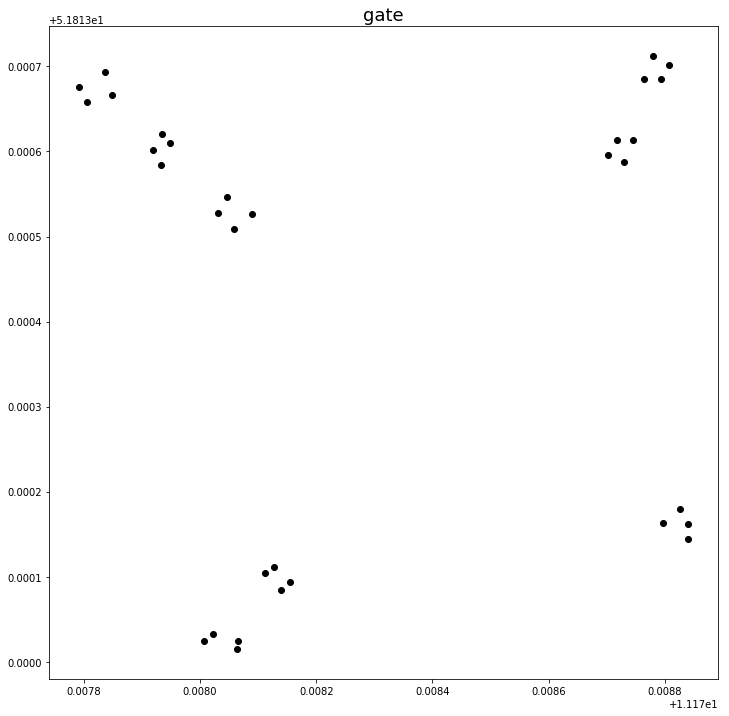

In [104]:
# PLOT 1
plt.figure(figsize=(12,12))
# PLOT POINTS
for element in gatemarker:
    plt.plot(element[0]['coordinates']['long'],element[0]['coordinates']['lat'], 'ko')
    plt.plot(element[1]['coordinates']['long'],element[1]['coordinates']['lat'], 'ko')
# PLOT LINES
    #plt.plot([element[0]['coordinates']['long'],element[1]['coordinates']['long'] ],[element[0]['coordinates']['lat'],element[1]['coordinates']['lat']], 'r-')

plt.title('gate', fontsize=18)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)

plt.show()

In [142]:
# FIT 
def Fit(long=11.1784, lat=51.8134, center=False):
    plt.figure(figsize=(11,11))
    model = lmfit.models.LinearModel()
    azimuth=list()
    for j in range(len(fitmarkerleft)):
        lon1=list()
        lat1=list()

        for i in range(len(fitmarkerleft[j][0])):
            lon1.append(fitmarkerleft[j][0][i]['coordinates']['long'])
            lat1.append(fitmarkerleft[j][0][i]['coordinates']['lat'])
            #define center
            if center==True:
                lat1.append(lat)
                lon1.append(long)
        fit1 = model.fit(lat1,x=lon1)
        plt.plot(lon1, fit1.best_fit, 'r-')
        #print(fit1.values,fitmarkerleft[j][1] )
        if fitmarkerleft[j][1]=="NE":
            azim=90-abs(math.atan(fit1.values["slope"])*180/3.14)
        if fitmarkerleft[j][1]=="SE":
            azim=90+abs(math.atan(fit1.values["slope"])*180/3.14)
        if fitmarkerleft[j][1]=="SW":
            azim=270-abs(math.atan(fit1.values["slope"])*180/3.14) 
        if fitmarkerleft[j][1]=="NW":
            azim=270+abs(math.atan(fit1.values["slope"])*180/3.14)  
        azimuth.append((fitmarkerleft[j][1], azim))

    for j in range(len(fitmarkerright)):
        lon2=list()
        lat2=list()
        for i in range(len(fitmarkerright[j][0])):

            lon2.append(fitmarkerright[j][0][i]['coordinates']['long'])
            lat2.append(fitmarkerright[j][0][i]['coordinates']['lat'])
            # define center
            if center==True:
                lat2.append(lat)
                lon2.append(long)

        fit2 = model.fit(lat2,x=lon2)
        plt.plot(lon2, fit2.best_fit, 'r-')
        #print(fit2.values, fitmarkerright[j][1])
        if fitmarkerright[j][1]=="NE":
            azim=90-abs(math.atan(fit2.values["slope"])*180/3.14)
        if fitmarkerright[j][1]=="SE":
            azim=90+abs(math.atan(fit2.values["slope"])*180/3.14)
        if fitmarkerright[j][1]=="SW":
            azim=270-abs(math.atan(fit2.values["slope"])*180/3.14) 
        if fitmarkerright[j][1]=="NW":
            azim=270+abs(math.atan(fit2.values["slope"])*180/3.14)  
        azimuth.append((fitmarkerright[j][1], azim))
        
    plt.legend=False
    plt.ylim((51.813, 51.814)) 
    plt.title('gate', fontsize=18)
    plt.xlabel('', fontsize=18)
    plt.ylabel('', fontsize=18)
    plt.show()
    return pd.DataFrame(sorted(azimuth), columns=['Sector', 'Azimuth[°]'])
    

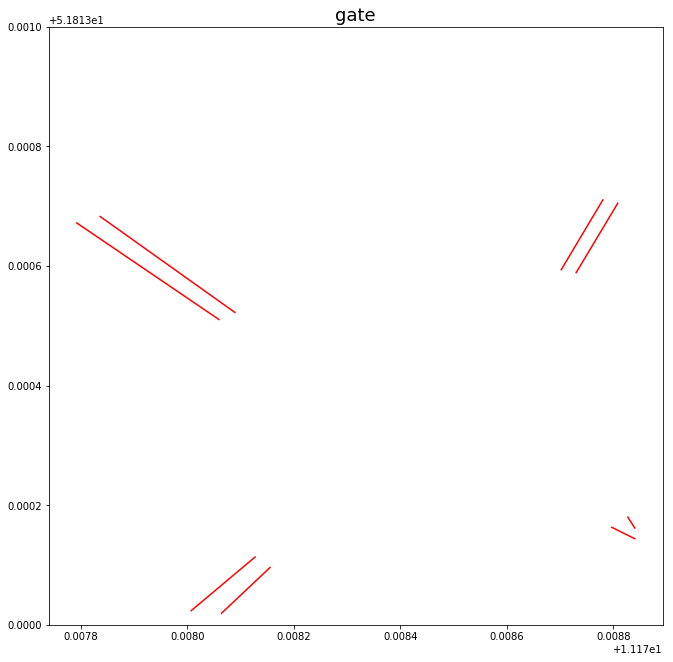

,Sector,Azimuth[°]
0,NE,33.769689
1,NE,33.936128
2,NW,301.184881
3,NW,302.388027
4,SE,113.850832
5,SE,144.189819
6,SW,229.937563
7,SW,233.184848


In [143]:
Fit()